# Marginalized Gaussian Mixture Model
---
---

**Importing the required libraries**

In [1]:
using Turing, Distributions, Distributed, MCMCChains

using Plots, StatsPlots

using Random
Random.seed!(12);

Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/riteshk/.julia/packages/Turing/yF1Mq/src/Turing.jl:24


Gaussian mixtures are a  flexible class of models for data that exhibits subpopulation heterogeneity. A toy example of such a data set is shown below.

**Generating the data**

In [10]:
N = 1000

W = [0.35, 0.4, 0.25]
μ = [0., 2., 5.]
σ = [0.5, 0.5, 1.]

choice = rand(Categorical(W), N)
print(component)
X = Vector(undef, N)
for i in 1:N
    X[i] = rand(Normal(μ[choice[i]], σ[choice[i]]))
end;

Distributions.component(1000,)

**Plotting the Data**

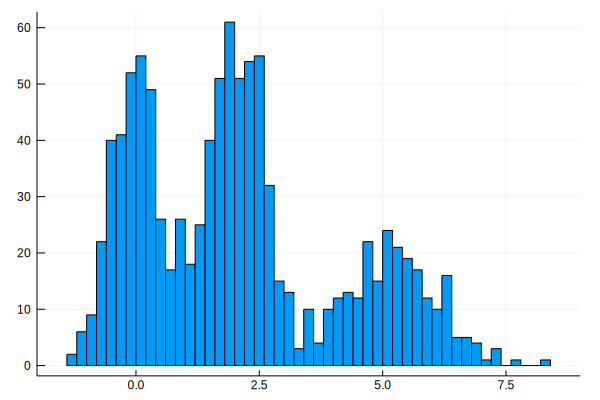

In [13]:
histogram(X, bins=50, legend=false)

A natural parameterization of the Gaussian mixture model is as the [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model)
$$
\mu_1,...,\mu_K\sim N(0,\sigma^2)\\
\tau_1,...\tau_K\sim Gamma(a, b)\\
w\sim Dirichlet(\alpha)\\
z | w\sim Categorical(w)\\
x | z\sim N(\mu_z, \tau_z^{-1})
$$

A drawback of this parameterization is that is posterior relies on sampling the discrete latent variable 𝑧. This reliance can cause slow mixing and ineffective exploration of the tails of the distribution.

An alternative, equivalent parameterization that addresses these problems is to marginalize over 𝑧. The marginalized model is
$$
\mu_1,...,\mu_K\sim N(0,\sigma^2)\\
\tau_1,...\tau_K\sim Gamma(a, b)\\
w\sim Dirichlet(\alpha)\\
f(x | w) = \sum_{k=1}^Kw_kN(x | \mu_k, \tau_k^{-1})\\
$$

Marginalizing 𝑧 out of the model generally leads to faster mixing and better exploration of the tails of the posterior distribution.

### Model: Marginalized GMM

In [15]:
@model MarginalizedGMM(X, K) = begin
    N = length(X)

    # Draw the paramters
    μ = Vector(undef, K)
    τ = Vector(undef, K)
    for i in 1:K
        μ[i] ~ Normal()
        τ[i] ~ Gamma()
    end

    # Set the Dirichlet prior.
    α = 1.0
    w ~ Dirichlet(K, α)

    # Calculate weighted Normals.
    for i in 1:N
      X[i] ~ MixtureModel(Normal, [(μ[i], 1/τ[i]) for i = 1:K], w)
    end
end;

### Sampling from Marginalized GMM

We will use **NUTS** for sampling

In [16]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using NUTS.

num_chains = 4
chns = mapreduce(c -> sample(MarginalizedGMM(X, 3), NUTS(1500, 200, 0.65) ), chainscat, 1:num_chains)

# describe(chain)

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245


MethodError: MethodError: no method matching MixtureModel(::Type{Normal}, ::Array{Tuple{ForwardDiff.Dual{ForwardDiff.Tag{getfield(Turing.Core, Symbol("#f#26")){Turing.Core.VarReplay.VarInfo,Turing.Model{Tuple{:μ,:τ,:w},Tuple{:X},getfield(Main, Symbol("###inner_function#419#51")){Int64},NamedTuple{(:X,),Tuple{Array{Any,1}}},NamedTuple{(:X,),Tuple{Symbol}}},Turing.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},Union{}}}},Real},Real,9},ForwardDiff.Dual{ForwardDiff.Tag{getfield(Turing.Core, Symbol("#f#26")){Turing.Core.VarReplay.VarInfo,Turing.Model{Tuple{:μ,:τ,:w},Tuple{:X},getfield(Main, Symbol("###inner_function#419#51")){Int64},NamedTuple{(:X,),Tuple{Array{Any,1}}},NamedTuple{(:X,),Tuple{Symbol}}},Turing.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},Union{}}}},Real},Float64,9}},1}, ::Array{ForwardDiff.Dual{ForwardDiff.Tag{getfield(Turing.Core, Symbol("#f#26")){Turing.Core.VarReplay.VarInfo,Turing.Model{Tuple{:μ,:τ,:w},Tuple{:X},getfield(Main, Symbol("###inner_function#419#51")){Int64},NamedTuple{(:X,),Tuple{Array{Any,1}}},NamedTuple{(:X,),Tuple{Symbol}}},Turing.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},Union{}}}},Real},Real,9},1})
Closest candidates are:
  MixtureModel(::Type{C<:Distribution}, ::AbstractArray) where C<:Distribution at /home/riteshk/.julia/packages/Distributions/WHjOk/src/mixtures/mixturemodel.jl:122
  MixtureModel(::Type{C<:Distribution}, ::AbstractArray, !Matched::Array{Float64,1}) where C<:Distribution at /home/riteshk/.julia/packages/Distributions/WHjOk/src/mixtures/mixturemodel.jl:139